In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import igraph as ig
import torch
import plotly.express as px
from src import Simulation as sim
from src import Dir_Reg
from src import Align
from src import visualize_latent_space as vls
from src import ABC_Reg

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
#a function that reads the dataset
def read_game_data(path):
    game_data = pd.read_json(path)
    game_data_copy = game_data.explode("teams").explode("teams")
    
    team_data = pd.json_normalize(game_data_copy["teams"])
    #after slicing, the index remains, so reset_index is needed. without "drop = True", we get two new columns of indices 
    team_0 = team_data[0: :2].reset_index(drop = True).add_suffix("_0")
    team_1 = team_data[1: :2].reset_index(drop = True).add_suffix("_1")
    #binds the sliced df together
    dataset = pd.concat([game_data.drop(columns="teams"), team_0, team_1], axis = 1)
    dataset["started_at"] = pd.to_datetime(dataset["started_at"])
    dataset["finished_at"] = pd.to_datetime(dataset["finished_at"])
    dataset.sort_values(by = "started_at")
    dataset = dataset.drop(columns = "map_id")
    dataset = dataset.rename(columns = {"profile_id_0": "player_0", 
                              "profile_id_1": "player_1", 
                              "civilization_1": "civ_1", 
                              "civilization_0": "civ_0", 
                              "civilization_randomized_0": "rand_civ_0", 
                              "civilization_randomized_1": "rand_civ_1"})
    return(dataset)

def map_player_ids(df, player_col_1, player_col_2):
    """
    Maps player IDs in a DataFrame to unique consecutive integers.

    Parameters:
    df (pd.DataFrame): DataFrame containing player match data.
    player_col_1 (str): Name of the first player column.
    player_col_2 (str): Name of the second player column.

    Returns:
    dict: A dictionary mapping player IDs to unique consecutive integers.
    list: A list of tuples representing the mapped edge list.
    """
    # Get unique players in the DataFrame
    unique_players = pd.unique(df[[player_col_1, player_col_2]].values.ravel())

    # Create a mapping from player IDs to consecutive integers
    player_id_to_index = {player_id: index for index, player_id in enumerate(unique_players)}

    # Map the player IDs in the edge list to consecutive integers
    mapped_edges = [(player_id_to_index[row[player_col_1]], player_id_to_index[row[player_col_2]]) for _, row in df.iterrows()]

    return player_id_to_index, mapped_edges



In [131]:
#load the dataset
# path = r"C:\Users\yangs\Downloads\games_qm_1v1_2023_q2.json\games_qm_1v1_2023_q2.json"
path = r"C:\Users\yangs\Downloads\games_rm_1v1_s5.json\games_rm_1v1_s5.json"
dataset = read_game_data(path)

In [316]:
dataset["patch"].unique()

array(['7.0.5861.0', '6.1.130.0', '6.0.878.0', '7.0.5976.0', '7.0.6026.0',
       '7.1.113.0', '8.1.185.0', '8.1.276.0', '8.2.218.0'], dtype=object)

In [319]:
temp = dataset.loc[:,["player_0", "player_1", "game_id", "started_at", "server", "mmr_0", "mmr_1"]].dropna(axis= 0 )

temp = temp[temp["started_at"].between("2023-06-16", "2023-08-16")]

p1 = temp.loc[:,["player_0", "mmr_0"]].rename(columns = {"player_0": "Player_ID", "mmr_0": "MMR"})
p2 = temp.loc[:, ["player_1", "mmr_1"]].rename(columns = {"player_1": "Player_ID", "mmr_1": "MMR"})
player = pd.concat([p1, p2]).groupby("Player_ID").agg(Mean_MMR = ("MMR", "mean"), Game_Count = ("MMR", "count")).reset_index()

group_0 = player[player["Mean_MMR"].between(850, 950)].copy()
group_0["Group"] = 0
group_1 = player[player["Mean_MMR"].between(1150, 1250)].copy()
group_1["Group"] = 1

selected_players = pd.concat([group_0, group_1])

selected_players = selected_players[selected_players["Game_Count"] > 30].copy()

In [320]:
selected_0 = selected_players["Player_ID"].tolist()
edge_0 = temp[temp["player_0"].isin(selected_0) & temp["player_1"].isin(selected_0)].loc[:, ["player_0", "player_1"]].drop_duplicates()


player_id_to_index, mapped_edges = map_player_ids(edge_0, 'player_0', 'player_1')
g = ig.Graph(edges = mapped_edges, directed = False)
A0 = torch.Tensor(g.get_adjacency().data)

In [318]:
selected_players["id"] = 

{11316088: 0,
 1299422: 1,
 6343853: 2,
 11179846: 3,
 9615718: 4,
 630751: 5,
 6630362: 6,
 7275430: 7,
 2586589: 8,
 10803779: 9,
 13402534: 10,
 3189102: 11,
 5653848: 12,
 9773224: 13,
 4453974: 14,
 11065358: 15,
 9519196: 16,
 9079105: 17,
 11618107: 18,
 15160273: 19,
 1395986: 20,
 8121655: 21,
 11823347: 22,
 838575: 23,
 9399238: 24,
 2395950: 25,
 4785445: 26,
 9999687: 27,
 9039502: 28,
 12171166: 29,
 9542417: 30,
 14813694: 31,
 9279104: 32,
 9742539: 33,
 9447364: 34,
 2682802: 35,
 7088946: 36,
 977304: 37,
 5257650: 38,
 3474161: 39,
 4633832: 40,
 6029743: 41,
 11272201: 42,
 2803450: 43,
 9295905: 44,
 12101434: 45,
 8206936: 46,
 10357545: 47,
 7073095: 48,
 7139484: 49,
 5505821: 50,
 15152969: 51,
 9829780: 52,
 10386597: 53,
 11898962: 54,
 8322428: 55,
 8755385: 56,
 10676070: 57,
 11653773: 58,
 15011319: 59,
 14748364: 60,
 11846584: 61,
 6176295: 62,
 6477497: 63,
 2108564: 64,
 14127840: 65,
 15201112: 66,
 5583232: 67,
 3379884: 68,
 7598683: 69,
 9082152: 

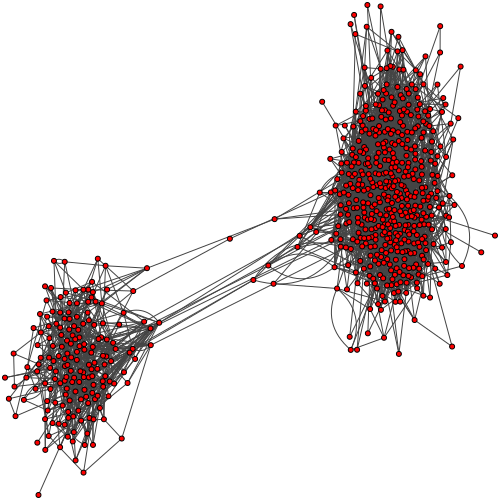

In [312]:
g.vs["size"] = 5

ig.plot(g, bbox=(500, 500), margin=5)


In [313]:
temp = Align.Op_Riemannian_GD(Align.Oracle.ASE(A0, 3), softplus_parameter = 1)

In [314]:
temp = Align.Op_Riemannian_GD(Align.Oracle.ASE(A0, 3), mode = "relu")
latpos_0 = pd.DataFrame((temp.data @ temp.align_mat).numpy())



# sns.scatterplot(data = latpos_0, x = 0, y = 1, s = 1)


fig = px.scatter_3d(data_frame = latpos_0, x = 0, y = 1, z = 2)
fig.update_traces(marker = dict(size = 1))

In [4]:
temp = dataset.loc[:,["player_0", "player_1", "game_id", "started_at", "server"]]

temp = temp[temp["started_at"].between("2023-06-16", "2023-07-16")]
player_0_counts = temp["player_0"].value_counts()
player_1_counts = temp["player_1"].value_counts()
player_counts = player_0_counts.add(player_1_counts, fill_value = 0).astype(int)
player_counts = player_counts.reset_index()
player_counts.columns = ["Player_ID", "Match_Count"]

freq_player_wk_1 = player_counts[player_counts["Match_Count"] > 10]["Player_ID"].to_list()

freq_subset = temp[temp["player_0"].isin(freq_player_wk_1) & temp["player_1"].isin(freq_player_wk_1)]
freq_subset = freq_subset.loc[:, ["player_0", "player_1"]].drop_duplicates()


player_id_to_index, mapped_edges = map_player_ids(freq_subset, 'player_0', 'player_1')
g = ig.Graph(edges = mapped_edges, directed = False)

A0 = torch.Tensor(g.get_adjacency().data)

In [36]:
temp = dataset.loc[:,["player_0", "player_1", "game_id", "started_at", "server"]]

temp = temp[temp["started_at"].between("2023-07-16", "2023-08-16")]
player_0_counts = temp["player_0"].value_counts()
player_1_counts = temp["player_1"].value_counts()
player_counts = player_0_counts.add(player_1_counts, fill_value = 0).astype(int)

player_counts = player_counts.reset_index()
player_counts.columns = ["Player_ID", "Match_Count"]

freq_player_wk_1 = player_counts[player_counts["Match_Count"] > 10]["Player_ID"].to_list()

freq_subset = temp[temp["player_0"].isin(freq_player_wk_1) & temp["player_1"].isin(freq_player_wk_1)]
freq_subset = freq_subset.loc[:, ["player_0", "player_1"]].drop_duplicates()


player_id_to_index, mapped_edges = map_player_ids(freq_subset, 'player_0', 'player_1')
g = ig.Graph(edges = mapped_edges, directed = False)

A1 = torch.Tensor(g.get_adjacency().data)
